In [22]:
import jax.numpy as jnp
import numpy as np
from pysersic import HybridRenderer
import matplotlib.pyplot as plt
from jax.random import PRNGKey

from pysersic.priors import autoprior
from pysersic import FitSingle
from pysersic.loss import student_t_loss

# Load up one of the canonical example galaxies
def load_data(n):
    im = np.load(f"examp_gals/gal{n}_im.npy")
    mask = np.load(f"examp_gals/gal{n}_mask.npy")
    sig = np.load(f"examp_gals/gal{n}_sig.npy")
    psf = np.load(f"examp_gals/gal{n}_psf.npy")
    return im, mask, sig, psf


im, mask, sig, psf = load_data(2)
renderer = HybridRenderer((100,100), pixel_PSF=jnp.array(psf))


In [81]:
r_eff_test = np.random.uniform(1.,5.,)
n_test = np.random.uniform(1.,6.,)
flux_test = np.random.uniform(50,300)
sersic_test_params = dict(xc= 50,yc = 51, flux = flux_test, r_eff = r_eff_test, n = n_test, ellip = 0.3, theta = 1.)
sersic_im = renderer.render_source(sersic_test_params, 'sersic') + jnp.array( np.random.normal(scale = 2e-2, size = (100,100)) )
rms_im = jnp.ones_like(sersic_im)*2e-2

prior  = autoprior(image = sersic_im, profile_type = 'spergel', sky_type = 'none')
fitter = FitSingle(data=sersic_im,rms=rms_im,psf=psf,prior=prior,loss_func=student_t_loss)
samp_res = fitter.sample(PRNGKey(101))
chains_pd = samp_res.idata.posterior.to_dataframe()

/Users/timothymiller/Documents/research/packages/pysersic/pysersic/pysersic/pysersic.py:152: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:05<00:00, 334.93it/s, 15 steps of size 3.14e-01. acc. prob=0.92]


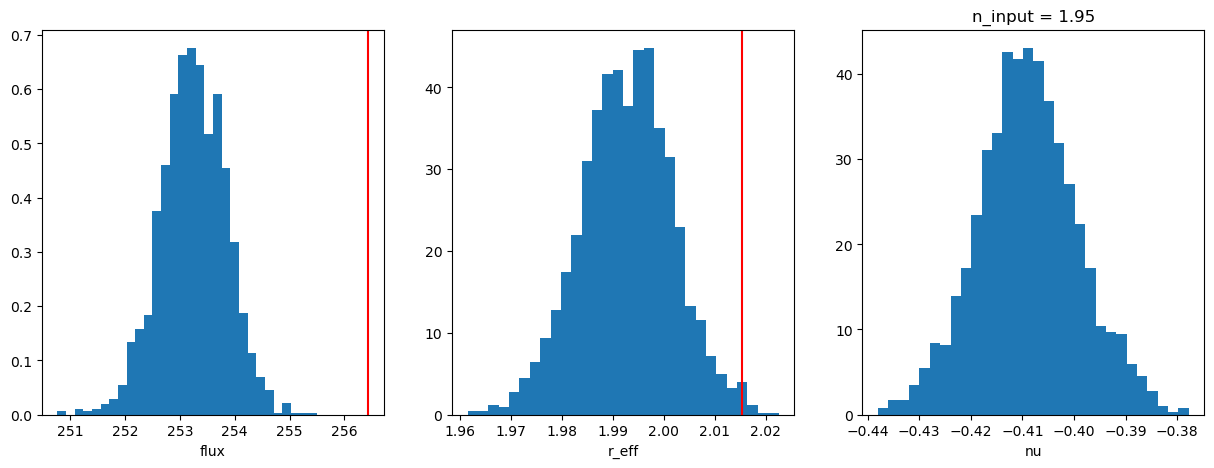

In [82]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))

ax1.hist(chains_pd['flux'], density = True, bins = 30)
ax1.set_xlabel('flux')
ax1.axvline(flux_test, c = 'r')
ax2.hist(chains_pd['r_eff'], density = True, bins = 30)
ax2.set_xlabel('r_eff')
ax2.axvline(r_eff_test, c = 'r')
ax3.hist(chains_pd['nu'], density = True, bins = 30)
ax3.set_xlabel('nu')
ax3.set_title(f'n_input = {n_test:.2f}')
plt.show()